# Import required libraries

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [99]:
torch.__version__

'2.1.0+cu121'

In [100]:
torchvision.__version__

'0.16.0+cu121'

## 2. Setup Device-Agnostic Code

In [101]:
!nvidia-smi

Mon Jun  9 15:20:07 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:65:00.0 Off |                  N/A |
| 36%   35C    P8              21W / 350W |   1966MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [102]:
torch.cuda.is_available()

True

In [103]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [104]:
print(f"Using Device: {device}")

Using Device: cuda


## 3. Set the seed

In [105]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

## 4. Setting the hyperprameters

In [106]:
3e-4

0.0003

In [107]:
BATCH_SIZE = 128
EPOCHS = 30 # Try increasing epochs to 30
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 100
IMAGE_SIZE = 32 # Transform the image and make the size go to 224
CHANNELS = 3
EMBED_DIM = 192
NUM_HEADS = 3# INcrease the number heads
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

## 5. Define Image Transformations

In [108]:

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

## 6. Getting a dataset

In [109]:
from torchvision import datasets

train_dataset = datasets.CIFAR100(root='data', train=True, transform=transform_train, download=True)


Files already downloaded and verified


In [110]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)


In [111]:
for x, y in train_loader:
    print(x.shape)  # Should be: torch.Size([BATCH_SIZE, 3, 224, 224])
    break


torch.Size([128, 3, 32, 32])


In [113]:
transform_test = transforms.Compose([
    transforms.Resize(32),  # Match model's expected input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [114]:
test_dataset = datasets.CIFAR100(root="data",
                                 train=False,
                                 download=True,
                                 transform=transform_test)


Files already downloaded and verified


In [115]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)


In [116]:
train_dataset

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [117]:
test_dataset

Dataset CIFAR100
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [118]:
len(train_dataset)

50000

In [119]:
len(test_dataset)

10000

## 7. Converting our datasets into dataloaders

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our data into batches or (mini-batches)

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memroy) at 50000 images in one hit. So we break it into 128 images at a time. (batch size of 128).
2. It gives our neural network more chances to update its gradients per epoch

In [120]:
BATCH_SIZE

128

In [122]:
# Let's check out what we've created
print(f"DataLoader: {train_loader, test_loader}")
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}...")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7fe883513580>, <torch.utils.data.dataloader.DataLoader object at 0x7fe883512f80>)
Length of train_loader: 391 batches of 128...
Length of test_loader: 79 batches of 128...


In [123]:
for x, y in train_loader:
    print(x.shape)  # Expect: (batch_size, 3, 224, 224)
    break


torch.Size([128, 3, 32, 32])


In [124]:
128 * 390.625

50000.0

In [125]:
50000 / 128

390.625

## 8. Building Vision Transformer Model From Scratch

In [126]:
PATCH_SIZE

4

In [127]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 img_size=32,
                 patch_size=4,
                 in_channels=3,
                 embed_dim=192):  
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels=in_channels,
                              out_channels=embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)
        
        num_patches = (img_size // patch_size) ** 2  # (32 / 4)^2 = 64
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))  # 1 + 64 = 65
        
        

    def forward(self, x: torch.Tensor):
        B = x.size(0)
        x = self.proj(x)                           # Shape: (B, E, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)           # Shape: (B, N, E)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)      # Shape: (B, 1+N, E)
        x = x + self.pos_embed                     # Positional embedding added
        return x


In [128]:
F

<module 'torch.nn.functional' from '/home/iiit/anaconda3/envs/a1/lib/python3.10/site-packages/torch/nn/functional.py'>

In [129]:
class MLP(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features,
                             out_features=in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [130]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

In [131]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.norm(x)
        cls_token = x[:, 0]
        return self.head(cls_token)

In [132]:
print(model.patch_embed.pos_embed.shape)


torch.Size([1, 65, 192])


In [133]:
DEPTH

6

In [134]:
device

'cuda'

In [135]:
# Instantiate model
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)

In [136]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
      )
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=192, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=192, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
      )
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

## 9. Defining a Loss function and an optimizer

In [137]:
criterion = nn.CrossEntropyLoss() # Measure how wrong our model is
optimizer = torch.optim.Adam(params=model.parameters(), # update our model's parameters to try and reduce the loss
                             lr=LEARNING_RATE)

In [138]:
criterion

CrossEntropyLoss()

In [139]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

## 10. Defining a Training Loop function

In [140]:
device

'cuda'

In [ ]:
def train(model, loader, optimizer, criterion):
    # Set the mode of the model into training
    model.train()

    total_loss, correct = 0, 0

    for x, y in loader:
        # Moving (Sending) our data into the target device
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        # 1. Forward pass (model outputs raw logits)
        out = model(x)
        # 2. Calcualte loss (per batch)
        loss = criterion(out, y)
        # 3. Perform backpropgation
        loss.backward()
        # 4. Perforam Gradient Descent
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
   
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [142]:
def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            correct += (preds.argmax(1) == y).sum().item()
            total += y.size(0)
    return 100 * correct / total


In [144]:
EPOCHS

30

In [145]:
print(model.patch_embed.pos_embed.shape)

torch.Size([1, 65, 192])


In [146]:
# Quick debug after your model definition and DataLoader setup
x, y = next(iter(train_loader))
print("Input batch shape:", x.shape)  # Expected: [batch_size, 3, 32, 32]
print("Positional embedding shape:", model.patch_embed.pos_embed.shape)

# Include a forward pass through only the patch embedding:
out = model.patch_embed(x.to(device))
print("Patch embed output shape:", out.shape)  # Should be [batch_size, 65, 192]


Input batch shape: torch.Size([128, 3, 32, 32])
Positional embedding shape: torch.Size([1, 65, 192])
Patch embed output shape: torch.Size([128, 65, 192])


In [147]:
# Rebuild the model and optimizer
model = VisionTransformer(
    img_size=32,
    patch_size=4,
    in_channels=3,
    num_classes=100,
    embed_dim=192,
    depth=6,
    num_heads=3,
    mlp_dim=512,
    drop_rate=0.1
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [148]:
from tqdm.auto import tqdm

In [149]:
### Training
train_accuracies, test_accuracies = [], []

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}%, Test acc: {test_acc:.4f}")

  3%|▎         | 1/30 [00:45<22:12, 45.96s/it]

Epoch: 1/30, Train loss: 4.2227, Train acc: 0.0563%, Test acc: 9.2300


  7%|▋         | 2/30 [01:31<21:26, 45.94s/it]

Epoch: 2/30, Train loss: 3.8524, Train acc: 0.1069%, Test acc: 14.8800


 10%|█         | 3/30 [02:18<20:45, 46.11s/it]

Epoch: 3/30, Train loss: 3.6530, Train acc: 0.1408%, Test acc: 18.7200


 13%|█▎        | 4/30 [03:04<20:00, 46.19s/it]

Epoch: 4/30, Train loss: 3.5068, Train acc: 0.1635%, Test acc: 20.7500


 17%|█▋        | 5/30 [03:49<19:05, 45.82s/it]

Epoch: 5/30, Train loss: 3.3642, Train acc: 0.1921%, Test acc: 23.4200


 20%|██        | 6/30 [04:32<17:53, 44.75s/it]

Epoch: 6/30, Train loss: 3.2526, Train acc: 0.2106%, Test acc: 23.9000


 23%|██▎       | 7/30 [05:15<16:57, 44.23s/it]

Epoch: 7/30, Train loss: 3.1532, Train acc: 0.2291%, Test acc: 26.5200


 27%|██▋       | 8/30 [06:01<16:26, 44.82s/it]

Epoch: 8/30, Train loss: 3.0569, Train acc: 0.2485%, Test acc: 29.2300


 30%|███       | 9/30 [06:48<15:52, 45.33s/it]

Epoch: 9/30, Train loss: 2.9742, Train acc: 0.2628%, Test acc: 29.4200


 33%|███▎      | 10/30 [07:34<15:13, 45.69s/it]

Epoch: 10/30, Train loss: 2.8979, Train acc: 0.2788%, Test acc: 31.2200


 37%|███▋      | 11/30 [08:20<14:32, 45.91s/it]

Epoch: 11/30, Train loss: 2.8199, Train acc: 0.2920%, Test acc: 32.0000


 40%|████      | 12/30 [09:07<13:47, 45.97s/it]

Epoch: 12/30, Train loss: 2.7552, Train acc: 0.3066%, Test acc: 33.2500


 43%|████▎     | 13/30 [09:53<13:04, 46.14s/it]

Epoch: 13/30, Train loss: 2.6902, Train acc: 0.3171%, Test acc: 35.3700


 47%|████▋     | 14/30 [10:40<12:20, 46.30s/it]

Epoch: 14/30, Train loss: 2.6186, Train acc: 0.3328%, Test acc: 36.0300


 50%|█████     | 15/30 [11:26<11:35, 46.38s/it]

Epoch: 15/30, Train loss: 2.5596, Train acc: 0.3454%, Test acc: 36.8100


 53%|█████▎    | 16/30 [12:13<10:49, 46.41s/it]

Epoch: 16/30, Train loss: 2.4967, Train acc: 0.3585%, Test acc: 38.0900


 57%|█████▋    | 17/30 [12:59<10:00, 46.22s/it]

Epoch: 17/30, Train loss: 2.4348, Train acc: 0.3711%, Test acc: 38.2500


 60%|██████    | 18/30 [13:44<09:11, 45.94s/it]

Epoch: 18/30, Train loss: 2.3766, Train acc: 0.3823%, Test acc: 39.0800


 63%|██████▎   | 19/30 [14:30<08:25, 45.92s/it]

Epoch: 19/30, Train loss: 2.3092, Train acc: 0.3955%, Test acc: 40.8600


 67%|██████▋   | 20/30 [15:16<07:40, 46.07s/it]

Epoch: 20/30, Train loss: 2.2549, Train acc: 0.4055%, Test acc: 42.2100


 70%|███████   | 21/30 [16:02<06:53, 45.90s/it]

Epoch: 21/30, Train loss: 2.1972, Train acc: 0.4201%, Test acc: 42.9600


 73%|███████▎  | 22/30 [16:48<06:07, 45.89s/it]

Epoch: 22/30, Train loss: 2.1416, Train acc: 0.4306%, Test acc: 42.2900


 77%|███████▋  | 23/30 [17:33<05:19, 45.64s/it]

Epoch: 23/30, Train loss: 2.0848, Train acc: 0.4456%, Test acc: 43.6300


 80%|████████  | 24/30 [18:18<04:34, 45.71s/it]

Epoch: 24/30, Train loss: 2.0400, Train acc: 0.4533%, Test acc: 44.1600


 83%|████████▎ | 25/30 [19:04<03:48, 45.72s/it]

Epoch: 25/30, Train loss: 1.9922, Train acc: 0.4644%, Test acc: 45.2700


 87%|████████▋ | 26/30 [19:50<03:03, 45.77s/it]

Epoch: 26/30, Train loss: 1.9471, Train acc: 0.4738%, Test acc: 44.7900


 90%|█████████ | 27/30 [20:36<02:17, 45.75s/it]

Epoch: 27/30, Train loss: 1.9177, Train acc: 0.4781%, Test acc: 45.8000


 93%|█████████▎| 28/30 [21:22<01:31, 45.94s/it]

Epoch: 28/30, Train loss: 1.8785, Train acc: 0.4867%, Test acc: 46.1000


 97%|█████████▋| 29/30 [22:08<00:46, 46.02s/it]

Epoch: 29/30, Train loss: 1.8369, Train acc: 0.4974%, Test acc: 47.0400


100%|██████████| 30/30 [22:54<00:00, 45.82s/it]

Epoch: 30/30, Train loss: 1.7956, Train acc: 0.5076%, Test acc: 47.3700


In [150]:
train_accuracies

[0.0563,
 0.10692,
 0.1408,
 0.16354,
 0.19206,
 0.2106,
 0.22914,
 0.24846,
 0.26284,
 0.27882,
 0.29202,
 0.3066,
 0.31708,
 0.33284,
 0.34544,
 0.35848,
 0.37114,
 0.38226,
 0.39548,
 0.40552,
 0.42008,
 0.43062,
 0.44564,
 0.45326,
 0.46444,
 0.47376,
 0.47806,
 0.48672,
 0.49744,
 0.50762]

In [151]:
test_accuracies

[9.23,
 14.88,
 18.72,
 20.75,
 23.42,
 23.9,
 26.52,
 29.23,
 29.42,
 31.22,
 32.0,
 33.25,
 35.37,
 36.03,
 36.81,
 38.09,
 38.25,
 39.08,
 40.86,
 42.21,
 42.96,
 42.29,
 43.63,
 44.16,
 45.27,
 44.79,
 45.8,
 46.1,
 47.04,
 47.37]

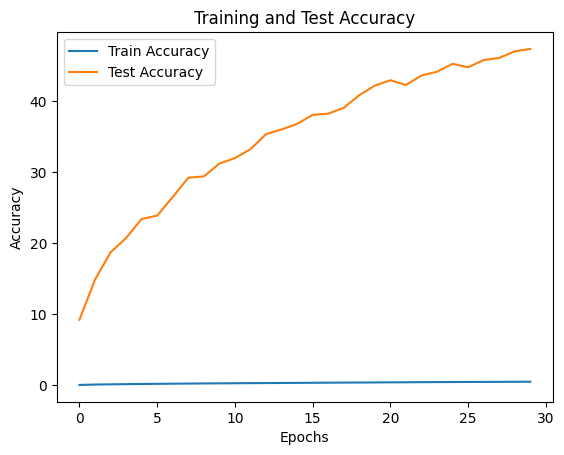

In [152]:
# Plot accuracy
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()

In [153]:
import random

In [154]:
len(test_dataset)

10000

In [155]:
test_dataset[0][0].unsqueeze(dim=0).shape

torch.Size([1, 3, 32, 32])

In [156]:
test_dataset[0][0] / 2 + 0.5

tensor([[[0.7804, 0.7686, 0.7647,  ..., 0.8471, 0.8510, 0.8784],
         [0.7725, 0.7647, 0.7647,  ..., 0.9059, 0.9137, 0.9451],
         [0.8706, 0.8353, 0.8196,  ..., 0.9529, 0.9569, 0.9804],
         ...,
         [0.2824, 0.2784, 0.2902,  ..., 0.8627, 0.7176, 0.6078],
         [0.2824, 0.2980, 0.3294,  ..., 0.8706, 0.7333, 0.5686],
         [0.3137, 0.3294, 0.3333,  ..., 0.8510, 0.8118, 0.6902]],

        [[0.8431, 0.8275, 0.8235,  ..., 0.9059, 0.9059, 0.9176],
         [0.8235, 0.8157, 0.8235,  ..., 0.9529, 0.9529, 0.9608],
         [0.8863, 0.8627, 0.8588,  ..., 0.9804, 0.9765, 0.9804],
         ...,
         [0.2863, 0.2902, 0.3059,  ..., 0.8157, 0.6588, 0.5529],
         [0.2941, 0.3176, 0.3490,  ..., 0.8314, 0.6824, 0.5176],
         [0.3333, 0.3529, 0.3608,  ..., 0.8118, 0.7608, 0.6431]],

        [[0.9765, 0.9569, 0.9529,  ..., 0.9804, 0.9804, 0.9882],
         [0.9373, 0.9333, 0.9412,  ..., 0.9804, 0.9804, 0.9922],
         [0.9647, 0.9490, 0.9529,  ..., 0.9843, 0.9843, 0.

In [159]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5 # Unormalize our images to be able to plot them with matplotlib
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"

            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()